# Reinforcement Learning Project: PPO applied to Box2D environments

## Introduction
For my project the goal is to apply the __Proximal Policy Optimization (PPO)__ to train reinforcement learning (RL) agents on two of the OpenAI gym Box2D environments: __(1) Car Racing__ and __(2) Bipedal Walker__. I will be using __[stable-baselines3](https://github.com/DLR-RM/stable-baselines3)__ as the RL framework. Stable Baselines 3 is a pytorch version of the original tensorflow based Stable Baselines, which provides RL algorithms and various RL utility scripts to facilitate training on various environments.

## Box2D Environments

I chose the [Box2D environments](https://www.gymlibrary.dev/environments/box2d/index.html) since I wanted something more complicated than classical control but not as complex as [MuJoCo](https://mujoco.org/) based environments. The two Box2D environments I chose were [Car Racing](https://www.gymlibrary.dev/environments/box2d/car_racing/) and [Bipedal Walker](https://www.gymlibrary.dev/environments/box2d/bipedal_walker/). The reason for exluding [Lunar Landar](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) was because this appeared to be a popular environment chosen by other students.

### 1. Bipedal Walker

The goal of the bipedal walker is to walk to the end of the path. The bipedal walker has both a continous action and observation space. The action space consists of motor speed values in the range of `[-1,1]` for 4 joints (hips and knees). The observation space is a list of 24 physical measurements. Termination rewards include +300 for reaching the end, and -100 for falling. Applying torque (which affects the motor speed values) costs a number of points.

![bipedal_walker.gif](https://www.gymlibrary.dev/_images/bipedal_walker.gif)

### 2. Car Racing

The goal of car racing is to complete a loop of the track while remaining within the track. The bipedal walker has 3 continuous actions, consisting of the steering value (-1 full left and +1 full right), gas, and breaking. The observation space is a 96x96 pixel grid. Termination occurs when every track tile has been visited or if the car falls off the map. Each tile visited gives 1000/N points, where N is the total number of tracks visited, and 0.1 points are taken off every frame. Falling off gives -100 points.

![car_racing.gif](https://www.gymlibrary.dev/_images/car_racing.gif)

## Proximal Policy Optimization

For my project I chose the [Proximal Policy Optimization (PPO) algorithm](https://arxiv.org/abs/1707.06347) [1]. PPO is one of the most popular RL algorithms, if not the most, and it is relatively simple while being robust due to its stability. It performs well on a vast array of environments.

PPO comes from the family of policy gradient methods for reinforcement learning.The central idea of PPO is to enforce a constraint on the policy update, limiting the change to a small region around the current policy. This constraint is crucial for ensuring stability during training.

The __objective function__ in PPO is a combination of the policy improvement term and the policy constraint term. The clipped surrogate objective is defined as follows:

$$
\begin{equation}
L(\theta) = \mathbb{E}_t\left[\min\left(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)\hat{A}_t\right)\right]
\end{equation}
$$

where $r_t(\theta)=\frac{\pi_θ(a_t∣s_t)}{\pi_{old}(a_t∣s_t)},$ $A^t$ is the estimated advantage function, and $\epsilon$ is a hyperparameter controlling the degree of policy change.

The __advantage function in PPO__ can be estimated using a value function. The advantage is calculated as the difference between the observed returns and the value function predictions:

$$
\begin{equation}
\hat{A}_t = \sum_{i=0}^{T-t} \gamma^i r_{t+i} - V_\theta(s_t)
\end{equation}
$$

where $\gamma$ is the discount factor, $T$ is the total number of time steps, $r_{t+i}$ is the observed return at time $t+i$, and $V_{\theta}(s_t)$ is the estimated value of the state $s_t$.

These equations form the core of the PPO algorithm, where the objective function is optimized to update the policy parameters ($\theta$) iteratively.

[1] Schulman, John, et al. "Proximal policy optimization algorithms." arXiv preprint arXiv:1707.06347 (2017).

# Approach and Experiments

## RL Baselines3 Zoo

[RL Baselines3 Zoo](https://github.com/DLR-RM/stable-baselines3) is a RL training framework built on top of Stable Baselines 3. It provides the tools to train agents with PPO on both Box2D environments, and to generate results such as reward plots and video recordings. We can either directly use RL Baselines3 Zoo as a python library (rl_zoo3) or we can use it as a command line tool. Here __I will be interacting with RL Baselines3 Zoo primarily via the command line API__.

One of the benefits to RL Baselines3 Zoo is that it has carefully selected hyperparameters for each of the environments. Choosing the default hyperparameters is then a good choice when training an agent on the provided Gym environments.

## Procedure
The procedure will be the following:

1. __Train PPO on both box 2d environments__
   * Bipedal Walker
   * Car Racing
2. __Generate results__
   * For each agent trained:
     * Plot reward over time
     * Record and display video of best agent

## Training

For training on each environment we will use the command line API for RL Baselines3 Zoo. The command can be run within a jupyter notebook but in my case I ran them in a terminal. The commands are commented out but are included for reference.

### Bipedal Walker

The following command was run to train an agent with PPO on the Bipedal Walker environment. It uses a feedfoward neural network (not a CNN) to learn the policy. The command is commented out here since it was run via a terminal outside of the notebook.

In [17]:
#!python -m rl_zoo3.train --algo ppo --env BipedalWalker-v3

### Car Racing

The following command was run to train an agent with PPO on the Car Racing environment. It uses a convolutional neural network (CNN) to learn the policy as the observation space is a 96x96 grid of pixels. The command is commented out here since it was run via a terminal outside of the notebook.

In [ ]:
#!python -m rl_zoo3.train --algo ppo --env CarRacing-v2

I additionally trained using a feedfoward neural network (not a CNN) to see how it would perform:

In [ ]:
#!python -m rl_zoo3.train --algo ppo --env CarRacing-v2 --env-kwargs policy:'MlpPolicy'

# Results

* Necessary imports to generate results

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3.common.results_plotter import load_results, ts2xy

import base64
from pathlib import Path

from IPython import display as ipythondisplay

In [20]:
LOG_DIR = f'rl-baselines3-zoo/logs/ppo/'

* Helper function for plotting reward over time

In [16]:
# Ref:
#  https://github.com/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/monitor_training.ipynb for plots
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

* Helper function for showing the video

In [1]:
# Ref
# https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/rl-baselines-zoo.ipynb

def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

## Bipedal Walker

### Reward Plot

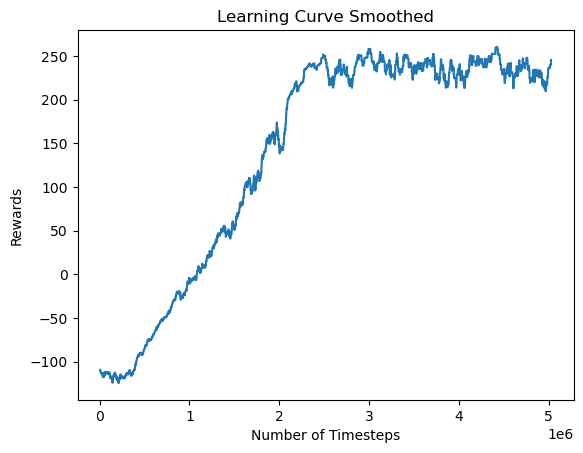

In [21]:
env = 'BipedalWalker-v3_2'
bipedal_dir = f'{LOG_DIR}/{env}'
plot_results(bipedal_dir)

* __Observation:__ The max reward peaked at ~250 at over 2e6 timesteps of training.

### Video Demo

* Command to record video using trained model:

In [ ]:
#!python -m rl_zoo3.record_video --algo ppo --env BipedalWalker-v3 --exp-id 2 -f logs/

* Play video

In [22]:
show_videos(video_path=f'{bipedal_dir}/videos/', prefix='')

* __Observation:__ The trained agent makes it to the end and prefers a skipping type motion. (Perhaps we shall present this to congress as the prefered walking motion.)

## Car Racing

* We trained with two different policies
   1. Normal neural network (MLP)
   2. Convolutional neural network (CNN)

### 1. MLP Policy

#### Reward Plot

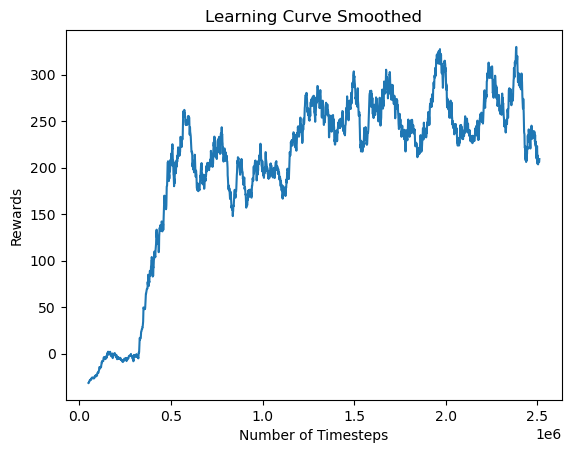

In [24]:
env = 'CarRacing-v2_1'
cr_mlp_dir = f'{LOG_DIR}/{env}'
plot_results(cr_mlp_dir)

* __Observation:__ The mean reward peaked at around 300 after ~2e6 timesteps.

#### Video Demo

* Command to record video using trained model:

In [28]:
#!python -m rl_zoo3.record_video --algo ppo --env CarRacing-v2 --exp-id 1 -f logs/

* Play video

In [25]:
show_videos(video_path=f'{cr_mlp_dir}/videos/', prefix='')

* __Observation:__ The agent trained with an MLP policy didn't know how to stay on the track!

### 2. CNN Policy

#### Reward Plot

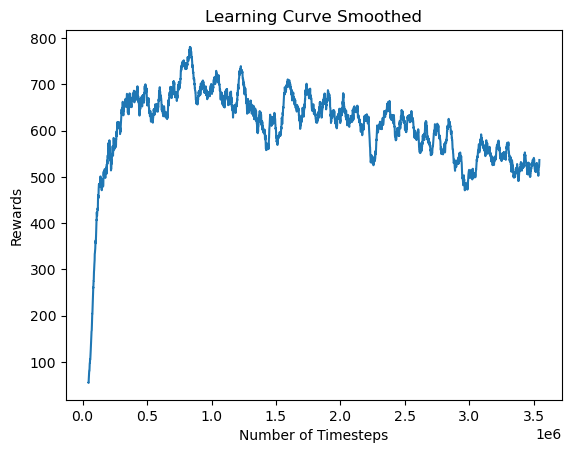

In [29]:
env = 'CarRacing-v2_3'
cr_cnn_dir = f'{LOG_DIR}/{env}'
plot_results(cr_cnn_dir)

* __Observation:__ The mean reward peaked at around 750 after ~1e6 timesteps. Over twice as good as the MLP based policy.

#### Video Demo

* Command to record video using trained model:

In [27]:
#!python -m rl_zoo3.record_video --algo ppo --env CarRacing-v2 --exp-id 3 -f logs/

* Play video

In [30]:
show_videos(video_path=f'{cr_cnn_dir}/videos/', prefix='')

* __Observation:__ This policy is much better but still has trouble staying on the track completely. When it veers off the track it displays an interesting behavior where it circles around. Still much better than the other MLP based polcy.

# Discussion and Conclusion

* Results summary
* What went well or not and why
* Suggestions for improvements or future work